<a href="https://colab.research.google.com/github/florindorian/MLP_from_scratch/blob/main/Notebooks/RedeMLP_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = "lime"> INTRODUÇÃO </font>
---

Este Colab notebook faz parte de um trabalho para a disciplina de Cálculo Numérico, cujo assunto é <font color = "lime">`Rede Neural MLP (Multi-Layer Perceptron)`</font>. Aqui, encontra-se a implementação da Rede em Python, incluindo:
+ Bibliotecas do Python usadas
+ Definição da classe que representa a rede MLP
+ Importação e análise do Dataset
+ Avaliação da precisão do modelo de classificação para o Dataset

Para ir diretamente para uma seção específica, selecione-a no botão de "índice" posicionado na barra lateral esquerda.

Caso os resultados não estejam pré-carregados nas células, ou por algum outro motivo seja necessário executar os códigos novamente, recomenda-se executar todas as células na ordem em que aparecem para evitar erros de dependência de código. Ou então, execute todas de uma vez usando o atalho `Ctrl + F9`.
<br><br><br>

**Autores:**
+ Florindo Rian Silva Carreteiro [![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/florindorian)
+ Paulo Beckman Santos Baia [![GitHub](https://img.shields.io/badge/github-%23121011.svg?style=for-the-badge&logo=github&logoColor=white)](https://github.com/paulobeckman)

**Publicado em:** Abril de 2024

**Última atualização:** 05/05/2024

# <font color='lime'>Bibliotecas e configurações</font>

In [ ]:
import numpy as np
import pandas as pd
import sklearn.datasets as datasets
import sklearn.metrics as mt
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# -- Configurações dos gráficos
plt.rcParams['figure.figsize'] = (10,6)
plt.style.use('dark_background')

# <font color='lime'>Implementação da Classe: </font> MlpModel
+ Inicialização dos pesos e bias
+ Feedforward
+ Cálculo da perda
+ Backpropagation
+ Fit

In [ ]:
class MlpModel:
  '''
  Classe Implementadora de uma rede neural do tipo Multi-layer Perceptron (Perceptron Multicamadas)
  '''

  # -- Definição dos atributos da rede MLP
  def __init__(self, x: np.ndarray, y: np.ndarray, hidden_neurons: int = 10, output_neurons: int = 2):
    '''
    Parâmetros:
    - x (numpy.ndarray): Array M x E de observações das variáveis de entrada.
        As colunas representam as variáveis, e as linhas as respectivas observações (instâncias).

    - y (numpy.ndarray): Vetor M x 1 dos resultados esperados

    - hidden_neurons (int): número de neurônios (perceptrons) ocultos

    - output_neurons (int): número de neurônios de saída (classes)
    '''
    np.random.seed(8)
    self.x = x                                                                                          # -- [M x E]
    self.y = y                                                                                          # -- [M x 1]
    self.hidden_neurons = hidden_neurons
    self.output_neurons = output_neurons
    self.input_neurons = self.x.shape[1]

    # -- Inicialização dos pesos e bias
    # -- Dados dos neurônios da camada Oculta (1)
    self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)    # -- [E x O]
    self.B1 = np.zeros((1, self.hidden_neurons))                                                        # -- [1 x O]
    self.z1 = 0                                                                                         # -- [M x O]
    self.f1 = 0                                                                                         # -- [M x O]

    # -- Dados dos neurônios da camada de Saída (2)
    self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)  # -- [O x S]
    self.B2 = np.zeros((1, self.output_neurons))                                                        # -- [1 x S]
    # -- Modelo da rede
    self.model_dict = {'W1': self.W1, 'B1': self.B1, 'W2': self.W2, 'B2': self.B2}

    # -- Dados de treino
    self.fit_accuracy = []
    self.fit_loss = []


  # -- Método de Treino da rede MLP
  def fit(self, epochs: int, lr: float):
    '''
    Parâmetros:
    - epochs (int): número de épocas ("Iterações") de treino
    - lr (float): Learning Rate (Taxa de Aprendizado)

    Retorno:
    - (numpy.ndarray): um array que contém as previsões para cada lista de valores de entrada (x)
    '''

    for epoch in range(epochs):
      outputs = self.forward(self.x) # -- forward retorna a softmax (as probabilidades de cada classe)
      loss = self.loss(outputs)
      self.backpropagation(outputs, lr)

      prediction = np.argmax(outputs, axis = 1) # -- classe com maior probabilidade

      # -- Quantidade de valores corretos, comparando valores preditos e valores de referência
      correct = (prediction == self.y).sum()
      accuracy = correct / self.y.shape[0]

      if int((epoch+1) % (epochs/10)) == 0: # -- Imprime os resultados a cada [(total de épocas) / 10] iterações, então há sempre 10 prints
        print(f'Epoch: [{epoch + 1} / {epochs}] Accuracy: {accuracy:.3f} Loss: {loss.item():.4f}') # -- Formatação da saída

      # -- Registro dos dados de treino
      self.fit_accuracy.append(accuracy)
      self.fit_loss.append(loss.item())

    return prediction # -- Retorna os valores para os quais foi feita a previsão


  # -- Método da etapa de Feedforward
  def forward(self, x: np.ndarray) -> np.ndarray:
    '''
    Parâmetros:
    - x (numpy.ndarray): Array M x E de observações das variáveis de entrada.
        As colunas representam as variáveis (features), e as linhas as respectivas observações (instâncias).

    Retorno:
    - (numpy.ndarray): o array "softmax" [M x S] de probabilidades obtidas para cada classe representada pelo respectivo neurônio de saída
    '''
    # -- Equação da reta (1):           z1 = x * W1 + B1      [M x E] @ [E x O] + [1 x O] = [M x O]
    self.z1 = x.dot(self.W1) + self.B1

    # -- Função de ativação (1):        f1 = tanh(z1)         [M x O]
    self.f1 = np.tanh(self.z1)

    # -- Equação da reta (2):           z2 = f1 * W2 + B2     [M x O] @ [O x S] + [1 x S] = [M x S]
    z2 = self.f1.dot(self.W2) + self.B2

    # -- Softmax
    exp_values = np.exp(z2)
    softmax = exp_values / np.sum(exp_values, axis = 1, keepdims = True)
    return softmax  # -- [M x S]


  # -- Método que implementa a Função de Perda (Cross Entropy):
  def loss(self, softmax):
    '''
    Parâmetros:
    - softmax (numpy.ndarray): o array "softmax" [M x S] de probabilidades obtidas para cada classe representada pelo respectivo neurônio de saída

    Retorno:
    - (numpy.float64): o valor que representa a perda em relação à saída gerada
    '''
    # -- Seleção das probabilidades correspondentes às classes corretas/esperadas
    predictions = np.zeros(self.y.shape[0]) # -- [M x 1]
    for i, correct_index in enumerate(self.y):
      predicted = softmax[i][correct_index] # -- A função de perda só é calculada em relação à classe correta/esperada
      predictions[i] = predicted

    # -- Cross Entropy:             CE = - y * log(ÿ)   ; y = 1 (pois 1 representa a probabilidade de se estar certo. Logo, sempre será o valor esperado)
    log_prob = -np.log(predictions)

    return log_prob.mean() # -- numpy.float64


  # -- Método que implementa a Retropropagação:
  def backpropagation(self, softmax: np.ndarray, learning_rate: float) -> None:
    '''
    Faz o ajuste dos pesos e bias somando uma parcela de ajuste a eles

    Parâmetros:
    - softmax (numpy.ndarray): o array "softmax" [M x S] de probabilidades obtidas para cada classe representada pelo respectivo neurônio de saída
    - learning_rate (float): Learning Rate (Taxa de Aprendizado)
    '''

    delta2 = np.copy(softmax)                         # -- [M x S]
    delta2[range(self.x.shape[0]), self.y] -= 1       # -- dE/dÿ * dÿ/dz2 = ( - y * log(ÿ) )' * ( softmax(z2) )' = ÿ - 1
    # -- z2 = w2 * f1 + b2
    # -- dW2: derivada do erro em relação a w2        # -- ( dE/dÿ * dÿ/dz2 ) * dz2/dw2 = (ÿ - 1) * f1
    dW2 = (self.f1.T).dot(delta2)                     # -- [M x O]' @ [M x S] = [O x M] * [M x S] = [O x S]
    # -- dB2: derivada do erro em relação a b2
    dB2 = np.sum(delta2, axis = 0, keepdims = True)   # -- [M x S] --> [1 x S]

    delta1 = delta2.dot(self.W2.T) * (1-np.power(np.tanh(self.z1), 2))  # -- [ ( dE/dÿ * dÿ/dz2 ) * dz2/f1 * df1/dz1 ] = delta2 * w2 * tanh'(z1)
                                                                        # -- [M x S] @ [S x O] * [M x O] = [M x O]
    # -- dW1: derivada do erro em relação a w1        # -- [ ( dE/dÿ * dÿ/dz2 ) * dz2/f1 * df1/dz1 ] * dz1/dw1 = delta1 * x
    dW1 = (self.x.T).dot(delta1)                      # -- [M x E]' @ [M x O] = [E x M] @ [M x O] = [E x O]
    # -- dB1: derivada do erro em relação a b1
    dB1 = np.sum(delta1, axis = 0, keepdims = True)   # -- [E x O] --> [1 x O]

    # -- Atualização dos pesos e bias
    # -- w_{n+1} = w_{n} + n * dE/dw        (dE/dw = delta * y)
    # -- b_{n+1} = b_{n} + n * dE/db        (dE/db = delta)
    self.W1 += - learning_rate * dW1
    self.W2 += - learning_rate * dW2
    self.B1 += - learning_rate * dB1
    self.B2 += - learning_rate * dB2

  # -- Método a ser usado para obter a acurácia e a perda obtidas em cada época de treinamento
  def get_fit_performance(self):
    return self.fit_accuracy, self.fit_loss

In [ ]:
# -- Função para avaliar a eficácia em relação ao conjunto de Teste
def accuracy_test(x_test: np.ndarray, y_test: np.ndarray, model: MlpModel):
  len = y_test.shape[0]

  softmax = model.forward(x_test)
  predicted = np.zeros([len], dtype=int)
  for i in range(len):
    predicted[i] = softmax[i].argmax()

  comparation = np.zeros([len])
  for i in range(len):
    comparation[i] = predicted[i] == y_test[i]

  print(f'Accuracy: {comparation.sum()/len * 100:.2f}%')

In [ ]:
# -- Função para plotar os gráficos da acurácia e da perda na comparação entre as abordagens: Variáveis Nomarlizadas X Variáveis Não Normalizadas
def plot_fit_comparation(fit_accuracy, fit_loss, fit_accuracyN, fit_lossN):
  plt.figure(figsize=(20,5))  # -- Tamanho da figura
  plt.grid(True, linestyle='--', color='gray', linewidth=0.5) # -- Grade
  plt.xticks(list(range(0,epochs+1, 100)), rotation='vertical') # -- Graduação do eixo x
  plt.yticks([i/100 for i in range(0,101,5)]) # -- Graduação do eixo y
  plt.plot(list(range(1,epochs+1)), fit_accuracy, 'lightgreen', label='Accuracy without Normalization')
  plt.plot(list(range(1,epochs+1)), fit_loss, 'orange', label='Loss without Normalization')
  plt.plot(list(range(1,epochs+1)), fit_accuracyN, 'lime', label='Accuracy with Normalization')
  plt.plot(list(range(1,epochs+1)), fit_lossN, 'red', label='Loss with Normalization')
  plt.legend(loc='center', bbox_to_anchor=(0.5, 0.3)) # -- Legenda
  # -- Posição: bbox_to_anchor=(1,0.5) --> 0.5: Deslocamento Horizontal (% eixo X), 0.3: Deslocamento Vertical (% eixo Y)
  #             loc='upper right'      --> O centro do quadro da Legenda estará alinhado com o centro relativo anterior

  plt.show()

# Aplicação: <font color='yellow'>Breast cancer wisconsin (diagnostic) dataset</font>

In [ ]:
df = datasets.load_breast_cancer(as_frame=True) # -- Importação do dataset

In [ ]:
df['data']

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


## <font color='skyblue'>Treino e Medição da Acurácia </font>

In [ ]:
# -- Seleção dos dados
x = df.data.to_numpy().copy()[:,0:10]
xN = df.data.to_numpy().copy()[:,0:10]
y = df.target.to_numpy().copy()

# -- Normalização das variáveis em xN por Máximo e Mínimo
for i in list(range(xN.shape[1])):
  max = xN[:,i].max()
  min = xN[:,i].min()
  xN[:,i] = (xN[:,i] - min) / (max - min)

<font size="5">Proporções: </font><font color="red" size="5">Treino: 70% | Teste: 30%</font>

In [ ]:
# -- Divisão dos dados em conjuntos de treino e de teste
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, random_state=8)
xN_train, xN_test, yN_train, yN_test = train_test_split(xN, y, train_size=0.7, random_state=8)

In [ ]:
# -- Configuração dos hiperparâmetros
hidden = 6      # -- hidden = 6
output = 2      # -- output = 2
epochs = 7700   # -- epochs = 7700
lr = 0.0013     # -- lr = 0.0013

In [ ]:
# -- Treinamento com variáveis Não Normalizadas
cancerModel = MlpModel(x = x_train, y = y_train, hidden_neurons = hidden, output_neurons = output)
result = cancerModel.fit(epochs, lr)

Epoch: [770 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [1540 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [2310 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [3080 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [3850 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [4620 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [5390 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [6160 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [6930 / 7700] Accuracy: 0.633 Loss: 0.6572
Epoch: [7700 / 7700] Accuracy: 0.633 Loss: 0.6572


In [ ]:
# -- Treinamento com variáveis Normalizadas
cancerModelN = MlpModel(x = xN_train, y = yN_train, hidden_neurons = hidden, output_neurons = output)
resultN = cancerModelN.fit(epochs, lr)

Epoch: [770 / 7700] Accuracy: 0.947 Loss: 0.1364
Epoch: [1540 / 7700] Accuracy: 0.952 Loss: 0.1175
Epoch: [2310 / 7700] Accuracy: 0.965 Loss: 0.0969
Epoch: [3080 / 7700] Accuracy: 0.970 Loss: 0.0855
Epoch: [3850 / 7700] Accuracy: 0.972 Loss: 0.0790
Epoch: [4620 / 7700] Accuracy: 0.975 Loss: 0.0743
Epoch: [5390 / 7700] Accuracy: 0.975 Loss: 0.0710
Epoch: [6160 / 7700] Accuracy: 0.975 Loss: 0.0677
Epoch: [6930 / 7700] Accuracy: 0.975 Loss: 0.0673
Epoch: [7700 / 7700] Accuracy: 0.972 Loss: 0.0649


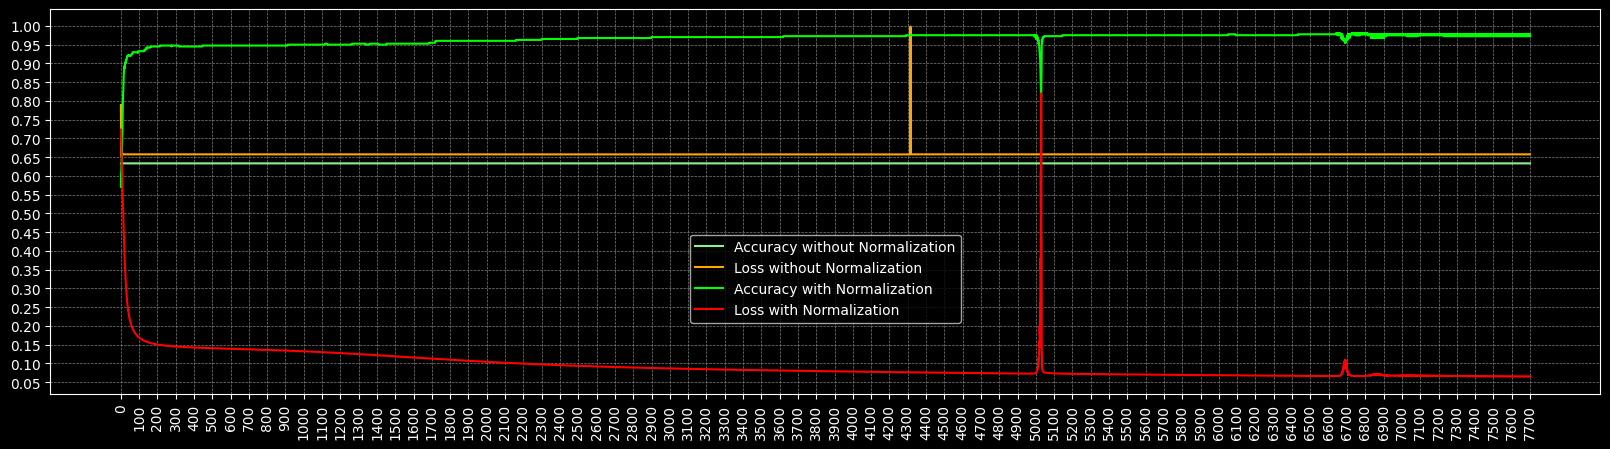

In [ ]:
# -- Plot comparativo entre os treinamentos com e sem normalização
fit_accuracy, fit_loss = cancerModel.get_fit_performance()
fit_accuracyN, fit_lossN = cancerModelN.get_fit_performance()

plot_fit_comparation(fit_accuracy, fit_loss, fit_accuracyN, fit_lossN)

In [ ]:
# -- Acurácia em relação ao conjunto de Teste
print("Com Variáveis Não Normalizadas: ")
accuracy_test(x_test, y_test, cancerModel)

print("\nCom Variáveis Normalizadas")
accuracy_test(xN_test, yN_test, cancerModelN)

Com Variáveis Não Normalizadas: 
Accuracy: 61.40%

Com Variáveis Normalizadas
Accuracy: 97.08%


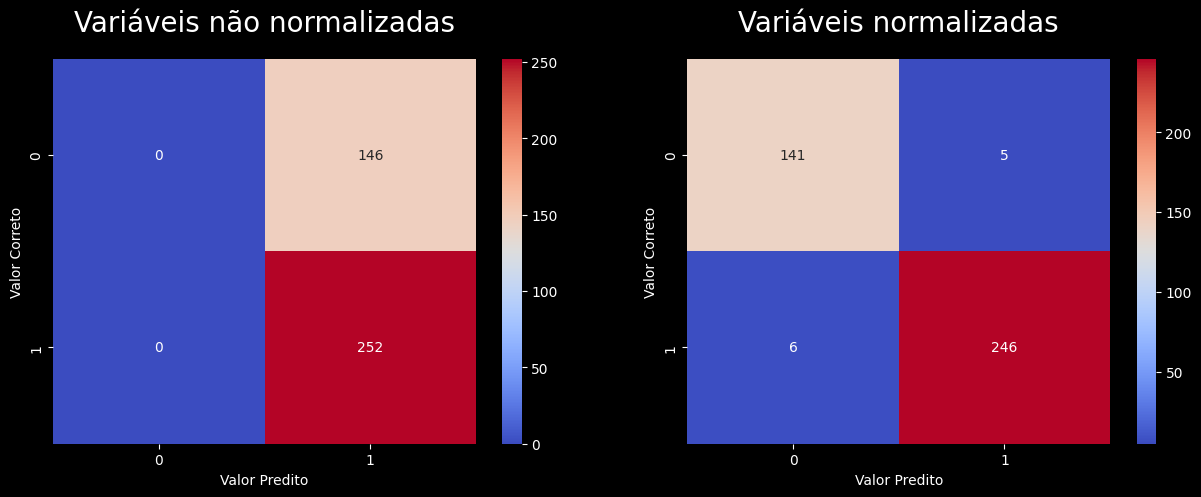

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.set_title('Variáveis não normalizadas', fontsize=20, y=1.05)
ax2.set_title('Variáveis normalizadas', fontsize=20, y=1.05)

confusion_matrix = mt.confusion_matrix(y_train, result)
confusion_matrix = pd.DataFrame(confusion_matrix).rename_axis("Valor Predito", axis=1).rename_axis("Valor Correto", axis=0)
sns.heatmap(confusion_matrix, annot=True, cmap='coolwarm', fmt='.0f', ax=ax1)

confusion_matrixN = mt.confusion_matrix(yN_train, resultN)
confusion_matrixN = pd.DataFrame(confusion_matrixN).rename_axis("Valor Predito", axis=1).rename_axis("Valor Correto", axis=0)
sns.heatmap(confusion_matrixN, annot=True, cmap='coolwarm', fmt='.0f', ax=ax2)

plt.show()

In [ ]:
# [VN FP]           [VN = Verdadeiros Negativos;  FP = Falsos positivos]
# [FN VP]           [FN = Falsos Negativos;       VP = Verdadeiros Positivos]

---
# <font color='lime'>Salvando o modelo treinado</font>

In [ ]:
# -- Para salvar o modelo treinado como um .pickle
with open('modelo_treinado.pickle', 'wb') as f:
  pickle.dump(cancerModelN, f) # -- Salvar 'bc' dentro de f

In [ ]:
# -- Para carregar um modelo treinado
# with open('/content/modelo_treinado.pickle', 'rb') as f:
#   modelo_carregado = pickle.load(f)